In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from umap import UMAP

from csd_simulations import (
    simulate_no_csd,
    simulate_no_csd_same_z,
    simulate_no_csd_large_z,
    simulate_csd,
    simulate_csd_corr,
)
from models import (
    train_ridge,
    train_rf,
    train_mlp,
    get_metrics
)

np.random.seed(42)

%load_ext autoreload
%autoreload 2

/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
n_domains = 5
n_per_domain = 50
p = 40
k = 5
noise_scale = 1.5

simulate_with_csd = True
simulate_same_z = True
correlated_noise = True

In [3]:
if k is not None:
    if simulate_with_csd:
        if correlated_noise:
            xs, ys = simulate_csd_corr(n_domains, n_per_domain, p, k, corr_top=0.5, diag=3)
        else:
            xs, ys = simulate_csd(n_domains, n_per_domain, p, k, noise_scale)
    else:
        xs, ys = simulate_no_csd_large_z(n_domains, n_per_domain, p, k, noise_scale)
elif simulate_same_z:
    xs, ys = simulate_no_csd_same_z(n_domains, n_per_domain, p, noise_scale)
else:
    xs, ys = simulate_no_csd(n_domains, n_per_domain, p, noise_scale)

print(xs.shape)
print(xs[:5, :5])

(250, 40)
[[ 6.41528190e-03  3.14876464e+00 -1.38442625e+00 -3.78051682e+00
  -2.95825108e+00]
 [ 2.37141477e+00  3.25947561e+00 -2.60986617e+00  7.96538700e-01
  -1.85974413e+00]
 [ 2.44046040e+00  6.97990643e+00  2.04834423e-01  3.35885340e+00
  -4.74280321e+00]
 [-2.58078668e+00  3.99236017e+00 -2.22451352e+00 -1.17752399e+00
  -1.95846686e+00]
 [ 2.04733901e+00  2.98044773e+00 -1.03117776e+00  6.11783201e-01
  -1.13902124e-01]]


In [4]:
print(ys.shape)
print(ys[:3, :])

(250, 1)
[[1]
 [1]
 [1]]


In [5]:
pca = PCA(n_components=2)
X_proj_pca = pca.fit_transform(xs)
reducer = UMAP(n_components=2, random_state=42)
X_proj_umap = reducer.fit_transform(xs)

domains = np.concatenate([([i] * n_per_domain) for i in range(n_domains)])

X_pca_df = pd.DataFrame(X_proj_pca,
                        columns=['PC{}'.format(j) for j in range(X_proj_pca.shape[1])])
X_pca_df['domain'] = domains
X_pca_df['label'] = ys.flatten()

X_umap_df = pd.DataFrame(X_proj_umap,
                        columns=['UMAP{}'.format(j) for j in range(X_proj_umap.shape[1])])
X_umap_df['domain'] = domains
X_umap_df['label'] = ys.flatten()

X_umap_df.head()

,UMAP0,UMAP1,domain,label
0,10.407293,3.710006,0,1
1,10.588058,3.317477,0,1
2,10.869676,3.528620,0,1
3,10.338672,4.996495,0,-1
4,10.259778,3.832859,0,1


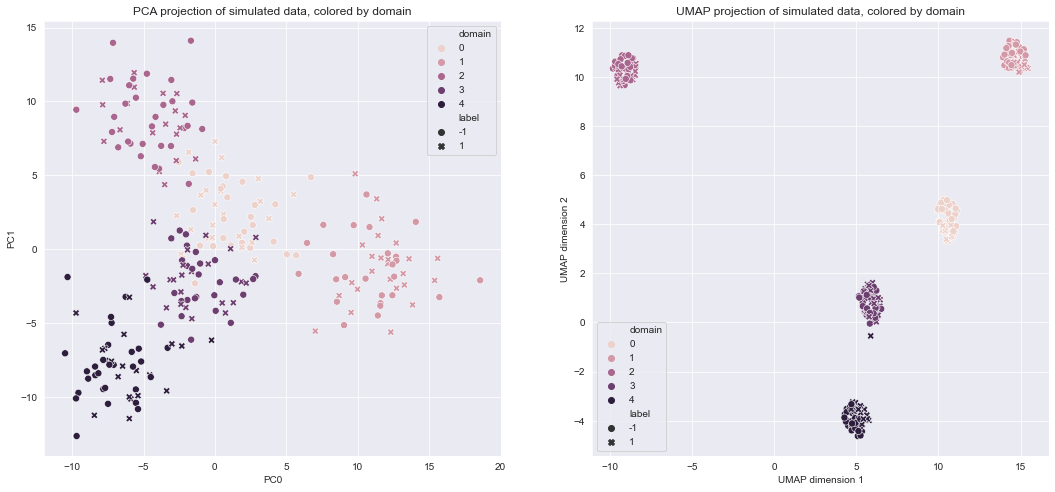

In [6]:
sns.set({'figure.figsize': (18, 8)})
fig, axarr = plt.subplots(1, 2)

sns.scatterplot(data=X_pca_df, x='PC0', y='PC1', hue='domain', style='label', s=50, ax=axarr[0])
sns.scatterplot(data=X_umap_df, x='UMAP0', y='UMAP1', hue='domain', style='label', s=50, ax=axarr[1])
    
axarr[0].set_title('PCA projection of simulated data, colored by domain')
axarr[1].set_xlabel('PC1')
axarr[1].set_ylabel('PC2')
axarr[0].legend()
axarr[1].set_title('UMAP projection of simulated data, colored by domain')
axarr[1].set_xlabel('UMAP dimension 1')
axarr[1].set_ylabel('UMAP dimension 2')
axarr[1].legend()

In [7]:
# split dataset into train/test
n_splits = 4
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs)):
    X_train, X_test = xs[train_ix, :], xs[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
 
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
 
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
 
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    params = {
        'learning_rate': [0.1, 0.01, 0.001, 5e-4, 1e-4],
        'h1_size': [100, 200, 300, 500],
        'dropout': [0.1, 0.5, 0.75],
        'weight_decay': [0, 0.1, 1, 10, 100]
    }
    
    fit_pipeline = train_mlp(X_train, y_train.flatten(), params, n_folds=-1, seed=42, max_iter=100)
    y_pred_train = fit_pipeline.predict_proba(X_train.astype(np.float32))[:, 1]
    y_pred_test = fit_pipeline.predict_proba(X_test.astype(np.float32))[:, 1]
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['mlp', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits


,model,fold,metric,value
0,ridge,0,train_auroc,0.828236
1,random_forest,0,train_auroc,0.888144
2,mlp,0,train_auroc,1.000000
3,ridge,1,train_auroc,0.853715
4,random_forest,1,train_auroc,0.987654


(-0.1, 1.1)

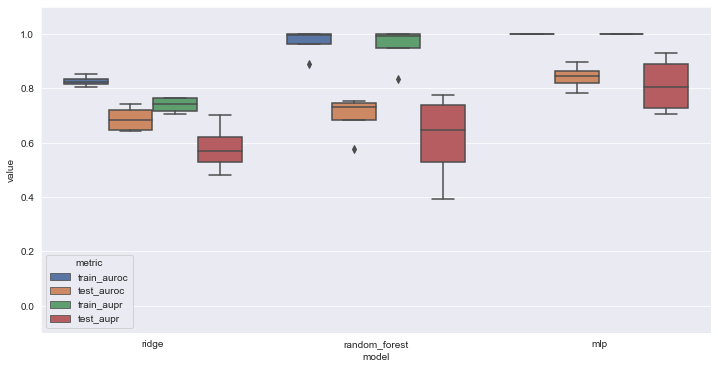

In [8]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.ylim(-0.1, 1.1)

In [9]:
x_covariates = pd.get_dummies(domains)
x_covariates.head()

,0,1,2,3,4
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [10]:
xs_fixed = np.concatenate((xs, x_covariates.values), axis=1)
print(xs_fixed[:5, :]) 

[[ 6.41528190e-03  3.14876464e+00 -1.38442625e+00 -3.78051682e+00
  -2.95825108e+00 -1.00968810e+00  1.76767803e+00 -2.57754520e+00
  -4.97118954e+00 -5.76010758e+00 -1.15545190e+00 -2.25067396e+00
   2.00345397e+00 -4.82409046e-04 -8.17519643e-02 -5.45022464e-01
  -2.43765896e+00  3.60511115e+00  4.40218079e+00  1.58357822e+00
  -1.51974565e+00 -3.28444323e+00 -7.02280627e+00  7.31205568e+00
   9.72760541e-01  1.34435821e-01 -3.61242790e+00 -5.46763419e+00
  -2.38180186e-01 -4.43782938e-01 -2.66741402e+00  2.12322400e+00
   3.72060070e+00  3.21278744e+00  7.23171087e-01  1.97506576e+00
   2.81300138e+00 -3.13586010e+00 -3.55922144e+00 -4.18638146e-01
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.37141477e+00  3.25947561e+00 -2.60986617e+00  7.96538700e-01
  -1.85974413e+00 -2.68113641e+00  6.00891727e-01 -3.06058158e+00
  -2.51264120e+00 -4.37489886e+00  5.63607803e-01 -5.14874618e+00
  -1.50502959e+00 -3.03027989e+00 -1.31843640e+00  1.3292

In [11]:
# split dataset into train/test
# this time with a covariate for domain membership (this should help performance)
results = []
results_cols = None

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
for fold, (train_ix, test_ix) in enumerate(kf.split(xs_fixed)):
    X_train, X_test = xs_fixed[train_ix, :], xs_fixed[test_ix, :]
    y_train, y_test = ys[train_ix, :], ys[test_ix, :]
    
    fit_pipeline = train_ridge(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
    
    metric_cols = list(metrics.keys()) + ['model', 'fold']
    metric_vals = list(metrics.values()) + ['ridge', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_rf(X_train, y_train.flatten(), seed=42)
    y_pred_train = fit_pipeline.predict(X_train)
    y_pred_test = fit_pipeline.predict(X_test)
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['random_forest', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
    fit_pipeline = train_mlp(X_train, y_train.flatten(), params, n_folds=-1, seed=42, max_iter=100)
    y_pred_train = fit_pipeline.predict_proba(X_train.astype(np.float32))[:, 1]
    y_pred_test = fit_pipeline.predict_proba(X_test.astype(np.float32))[:, 1]
    metrics = get_metrics(y_train, y_test, y_pred_train, y_pred_test)
                        
    metric_vals = list(metrics.values()) + ['mlp', fold]
    if results_cols is None:
        results_cols = metric_cols
    else:
        assert metric_cols == results_cols
    results.append(metric_vals)
    
results_df = pd.DataFrame(results, columns=results_cols)
results_df = results_df.melt(id_vars=['model', 'fold'], var_name='metric')
results_df.head()

Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits
Fitting 1 folds for each of 20 candidates, totalling 20 fits


,model,fold,metric,value
0,ridge,0,train_auroc,0.849656
1,random_forest,0,train_auroc,1.000000
2,mlp,0,train_auroc,1.000000
3,ridge,1,train_auroc,0.853715
4,random_forest,1,train_auroc,0.916143


(-0.1, 1.1)

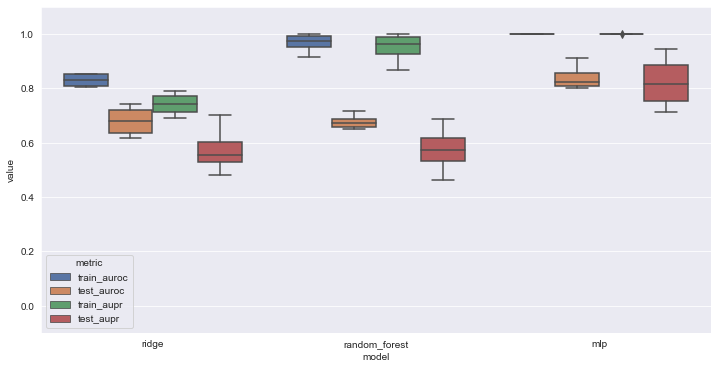

/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jake/miniconda3/envs/pc-eval/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

In [12]:
sns.set({'figure.figsize': (12, 6)})

sns.boxplot(data=results_df, x='model', y='value', hue='metric')
plt.ylim(-0.1, 1.1)